## Setup

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
from typing import Tuple

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, GRU, Reshape
from keras.applications.inception_v3 import preprocess_input
from keras.layers import GaussianNoise, Dropout

import time, os
import random
import shutil
from math import ceil
import multiprocessing
import pickle
import sys
import warnings

## Read in data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naihexiao","key":"dc003e05b496db6674191ae798c58498"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gpreda/chinese-mnist
!unzip chinese-mnist

Streaming output truncated to the last 5000 lines.
  inflating: data/data/input_6_6_5.jpg  
  inflating: data/data/input_6_6_6.jpg  
  inflating: data/data/input_6_6_7.jpg  
  inflating: data/data/input_6_6_8.jpg  
  inflating: data/data/input_6_6_9.jpg  
  inflating: data/data/input_6_7_1.jpg  
  inflating: data/data/input_6_7_10.jpg  
  inflating: data/data/input_6_7_11.jpg  
  inflating: data/data/input_6_7_12.jpg  
  inflating: data/data/input_6_7_13.jpg  
  inflating: data/data/input_6_7_14.jpg  
  inflating: data/data/input_6_7_15.jpg  
  inflating: data/data/input_6_7_2.jpg  
  inflating: data/data/input_6_7_3.jpg  
  inflating: data/data/input_6_7_4.jpg  
  inflating: data/data/input_6_7_5.jpg  
  inflating: data/data/input_6_7_6.jpg  
  inflating: data/data/input_6_7_7.jpg  
  inflating: data/data/input_6_7_8.jpg  
  inflating: data/data/input_6_7_9.jpg  
  inflating: data/data/input_6_8_1.jpg  
  inflating: data/data/input_6_8_10.jpg  
  inflating: data/data/input_6_8_11.jpg 

In [6]:
# chinese_mnist_df.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
data = pd.read_csv('chinese_mnist.csv', delimiter=',')
data.dataframeName = 'chinese_mnist_df.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 15000 rows and 5 columns


In [7]:
data.loc[(data['suite_id'] == 100) & (data['sample_id'] == 10) & (data['code'] == 10)]

,suite_id,sample_id,code,value,character
21,100,10,10,9,九


## Process and store data

In [8]:
labels = np.array([ x - 1 for x in data['code'].values ])
images = np.array([ cv2.resize(cv2.imread(f"/content/data/data/input_{suite_id}_{sample_id}_{code}.jpg", cv2.IMREAD_GRAYSCALE), (299, 299)) for suite_id, sample_id, code in data[['suite_id', 'sample_id', 'code']].values ])
indices = np.arange(len(images))
np.random.seed(413) 
np.random.shuffle(indices)
splited_indices = np.split(indices, [int(images.shape[0] * 0.6), int(images.shape[0] * 0.7)])
training_images, training_labels, validation_images, validation_labels, test_images, test_labels = \
          (images[splited_indices[0]], labels[splited_indices[0]], 
          images[splited_indices[1]], labels[splited_indices[1]], 
          images[splited_indices[2]], labels[splited_indices[2]])

In [9]:
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)
print(test_labels.shape)
assert(training_images.shape[0] + validation_images.shape[0] + test_images.shape[0] == 15000)

(9000, 299, 299)
(9000,)
(1500, 299, 299)
(1500,)
(4500, 299, 299)
(4500,)


In [10]:
# Create a directory to save the training images
if not os.path.exists('train_full'):
    os.makedirs('train_full')
# Create a directory to save the validation images
if not os.path.exists('val_full'):
    os.makedirs('val_full')
# Create a directory to save the test images
if not os.path.exists('test_full'):
    os.makedirs('test_full')

# Create subdirectories for each class
for i in range(15):
    if not os.path.exists(f'train_full/class_{i+1}'):
        os.makedirs(f'train_full/class_{i+1}')

# Move images to their respective class subdirectories
for i, image in enumerate(training_images):
    class_num = training_labels[i] + 1
    filename = f'train_full/class_{class_num}/image_{i}.jpg'
    cv2.imwrite(filename, image)

# Create subdirectories for each class
for i in range(15):
    if not os.path.exists(f'val_full/class_{i+1}'):
        os.makedirs(f'val_full/class_{i+1}')

# Move images to their respective class subdirectories
for i, image in enumerate(validation_images):
    class_num = validation_labels[i] + 1
    filename = f'val_full/class_{class_num}/image_{i}.jpg'
    cv2.imwrite(filename, image)

# Save the test images to the directory
for i, image in enumerate(test_images):
    filename = f'test_full/image_{i}.jpg'
    cv2.imwrite(filename, image)

## Utility functions

In [11]:
def dataloader_generator(train_path, train_datagen, val_path, val_datagen, data_size, dataset_type):
    """ Loads data from given pathes, store then in corresponding folders 
        and return generators for them."""
    # set the random seed
    random.seed(413)

    train_set_filename = dataset_type + "_train_set"
    val_set_filename = dataset_type + "_val_set"

    # loop through each class in the original training and validation sets
    for class_num in range(1, 16):
        
        # create a directory to store the new subset of the class
        if not os.path.exists(f'{train_set_filename}/class_{class_num}'):
            os.makedirs(f'{train_set_filename}/class_{class_num}')
        if not os.path.exists(f'{val_set_filename}/class_{class_num}'):
            os.makedirs(f'{val_set_filename}/class_{class_num}')
        
        # randomly select 20% of the samples for validation and the rest for training
        num_val_samples = int(0.2 * data_size)
        num_train_samples = data_size - num_val_samples

        # randomly select data_size samples from the original training and validation sets for the current class
        train_samples = random.sample(os.listdir(os.path.join(train_path, f'class_{class_num}')), num_train_samples)
        val_samples = random.sample(os.listdir(os.path.join(val_path, f'class_{class_num}')), num_val_samples)

        # move the training samples to the new training directory
        for sample in train_samples:
            image = cv2.imread(os.path.join(train_path, f'class_{class_num}', sample))
            filename = f'{train_set_filename}/class_{class_num}/{sample}'
            cv2.imwrite(filename, image)

        # move the validation samples to the new validation directory
        for sample in val_samples:
            image = cv2.imread(os.path.join(val_path, f'class_{class_num}', sample))
            filename = f'{val_set_filename}/class_{class_num}/{sample}'
            cv2.imwrite(filename, image)

    # create the data generators for the new training and validation sets
    train_generator = train_datagen.flow_from_directory(train_set_filename,
                                                  target_size=(299, 299),
                                                  batch_size=50,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=7)

    val_generator = val_datagen.flow_from_directory(val_set_filename,
                                                target_size=(299, 299),
                                                batch_size=50,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=7)
    return train_generator, val_generator

In [12]:
from keras.layers import Lambda, concatenate

def multi_gpu_model(model, gpus):
    """Generate keras.Model with possibly gpu version."""
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    
    # This part of the code places a copy of the original model on each GPU 
    # device specified by target_gpu_ids, and slices the inputs among the GPUs. 
    # The for loop goes through each GPU device and retrieves a slice of input 
    # for that particular GPU. The model is then applied to the sliced input, 
    # and the outputs are saved for merging back together later.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


In [13]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def print_opts(opts):
    """Prints the values of all command-line arguments."""
    print("=" * 80)
    print("Opts".center(80))
    print("-" * 80)
    for key in opts.__dict__:
        print("{:>30}: {:<30}".format(key, opts.__dict__[key]).center(80))
    print("=" * 80)

In [14]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


## Dataloaders

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=10,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocess_input
)


In [16]:
# set the path to the original training and validation sets
train_path = 'train_full'
val_path = 'val_full'
test_path = 'test_full'

small_datasize = 50
median_datasize = 100
large_datasize = 200

small_train_set, small_val_set = dataloader_generator(train_path, train_datagen, val_path, val_datagen, small_datasize, "small")
median_train_set, median_val_set = dataloader_generator(train_path, train_datagen, val_path, val_datagen, median_datasize, "median")
large_train_set, large_val_set = dataloader_generator(train_path, train_datagen, val_path, val_datagen, large_datasize, "large")

Found 600 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 1200 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 2400 images belonging to 15 classes.
Found 600 images belonging to 15 classes.


## Inception V3

In [17]:
def generate_model(freeze_base=False):
    """Generate a new Inception V3 model."""
    # Loading InceptionV3 model with ImageNet weights and removing top layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
    x = base_model.output

    # Adding Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)

    # Reshaping the tensor
    x = Reshape([1,2048])(x)  

    # Adding GRU layer
    x = GRU(2048, 
                return_sequences=False,                       
                # dropout=0.8                                     
                input_shape=[1,2048])(x)

    # Adding Gaussian noise layer for regularization
    x = GaussianNoise(0.1)(x)

    # Adding Dense layer with 1024 units and ReLU activation function
    x = Dense(1024, activation='relu')(x)

    # Adding Dense layer with 10 units and softmax activation function
    x = Dense(15, activation='softmax')(x)

    # Creating the final model
    model = Model(inputs=[base_model.input],outputs=[x])

    if freeze_base:
      # i.e. freeze all convolutional InceptionV3 layers
        for layer in base_model.layers:
            layer.trainable = False

    # Printing the summary of the model
    # print(model_1.summary())
    return model

## Train and evaluate

In [19]:
def train_evaluate(model, opts, train_dataset, val_dataset):
    """Train model with given opts on train_dataset and evaluate it on val_dataset."""
    # Using multiple models if more than 1 GPU
    if opts.gpus != 1:
        model_mul = multi_gpu_model(model, opts.gpus)
    else:
        model_mul = model

    #### setup checkpoint path
    model_name = "Inception3-GRU-bs{}-t{}-v{}".format(
        opts.batch_size, opts.train_data_set, opts.val_data_set
    )
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####
      
    epochs = opts.nepochs
    learning_rate = opts.learning_rate
    decay = learning_rate/epochs
    optimizer = Adam(lr=learning_rate, decay=decay)

    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        TensorBoard(log_dir='./logs')
    ]

    STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
    STEP_SIZE_VALID=val_dataset.n//val_dataset.batch_size

    train_history = model_mul.fit(
      train_dataset,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=val_dataset,
      validation_steps=STEP_SIZE_VALID,
      epochs=epochs,
      verbose=1,
      callbacks=callbacks
    )

    return train_history




                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: small_train_set                        
                           val_data_set: small_val_set                          
                                   gpus: 1                                      
                                nepochs: 80                                     
                          learning_rate: 0.0002                                 
                             batch_size: 80                                     


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/80
12/12 [==============================] - 47s 2s/step - loss: 2.4746 - accuracy: 0.2167 - val_loss: 2.8144 - val_accuracy: 0.0800
Epoch 2/80
12/12 [==============================] - 18s 1s/step - loss: 1.1857 - accuracy: 0.5967 - val_loss: 3.6326 - val_accuracy: 0.0667
Epoch 3/80
12/12 [==============================] - 17s 1s/step - loss: 0.5652 - accuracy: 0.8000 - val_loss: 3.6266 - val_accuracy: 0.0667
Epoch 4/80
12/12 [==============================] - 18s 1s/step - loss: 0.4693 - accuracy: 0.8483 - val_loss: 3.3105 - val_accuracy: 0.0667
Epoch 5/80
12/12 [==============================] - 17s 1s/step - loss: 0.3565 - accuracy: 0.8650 - val_loss: 4.0269 - val_accuracy: 0.0667
Epoch 6/80
12/12 [==============================] - 18s 1s/step - loss: 0.3571 - accuracy: 0.8783 - val_loss: 5.1778 - val_accuracy: 0.0667
Epoch 7/80
12/12 [==============================] - 17s 1s/step - loss: 0.3439 - accuracy: 0.8633 - val_loss: 5.3009 - val_accuracy: 0.0667
Epoch 8/80
12/12 [==

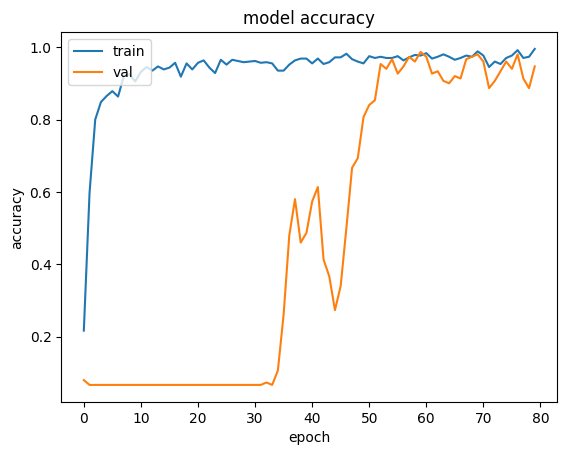

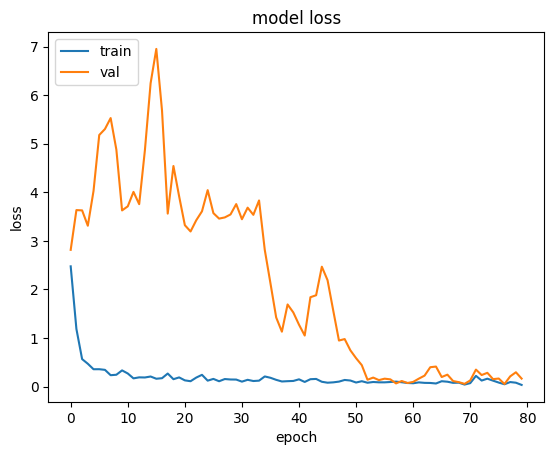

In [ ]:
model_args_s = AttrDict()
args_dict = {
    "train_data_set": "small_train_set",
    "val_data_set": "small_val_set",
    "gpus": 1,
    "nepochs": 80,
    "learning_rate": 2e-4,
    "batch_size": 80,
}

model_args_s.update(args_dict)

print_opts(model_args_s)

small_model = generate_model()

small_history = train_evaluate(small_model, model_args_s, small_train_set, small_val_set)

plot_accuracy(small_history)
plot_loss(small_history)


                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: median_train_set                       
                           val_data_set: median_val_set                         
                                   gpus: 1                                      
                                nepochs: 50                                     
                          learning_rate: 0.0001                                 
                             batch_size: 80                                     
Epoch 1/50
24/24 [==============================] - 44s 1s/step - loss: 2.1693 - accuracy: 0.3292 - val_loss: 2.7945 - val_accuracy: 0.0667
Epoch 2/50
24/24 [==============================] - 35s 1s/step - loss: 0.7762 - accuracy: 0.7250 - val_loss: 3.6050 - val_accuracy: 0.0667
Epoch 3/50
24/24 [==============================] - 34s 1s/step - loss: 

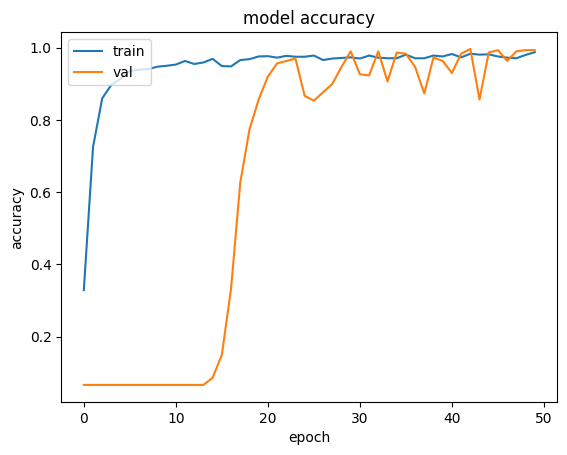

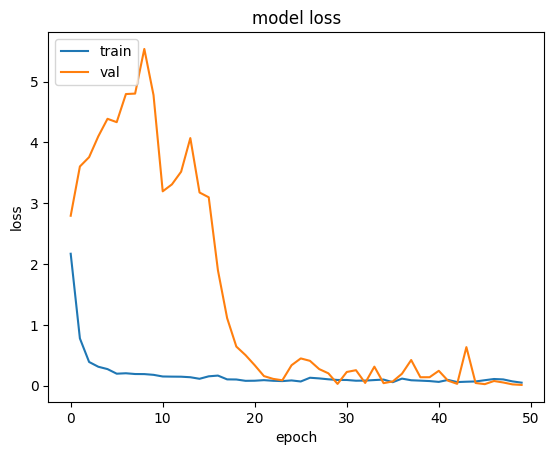

In [ ]:
model_args_s = AttrDict()
args_dict = {
    "train_data_set": "median_train_set",
    "val_data_set": "median_val_set",
    "gpus": 1,
    "nepochs": 50,
    "learning_rate": 1e-4,
    "batch_size": 80,
}

model_args_s.update(args_dict)

print_opts(model_args_s)

median_model = generate_model(False)

median_history = train_evaluate(median_model, model_args_s, median_train_set, median_val_set)

plot_accuracy(median_history)
plot_loss(median_history)


                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: large_train_set                        
                           val_data_set: large_val_set                          
                                   gpus: 1                                      
                                nepochs: 40                                     
                          learning_rate: 0.0001                                 
                             batch_size: 80                                     


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
48/48 [==============================] - 92s 1s/step - loss: 1.5141 - accuracy: 0.5354 - val_loss: 3.6289 - val_accuracy: 0.0667
Epoch 2/40
48/48 [==============================] - 64s 1s/step - loss: 0.3539 - accuracy: 0.8796 - val_loss: 3.4204 - val_accuracy: 0.0667
Epoch 3/40
48/48 [==============================] - 67s 1s/step - loss: 0.2496 - accuracy: 0.9187 - val_loss: 3.3201 - val_accuracy: 0.0667
Epoch 4/40
48/48 [==============================] - 64s 1s/step - loss: 0.1778 - accuracy: 0.9408 - val_loss: 4.3791 - val_accuracy: 0.0667
Epoch 5/40
48/48 [==============================] - 65s 1s/step - loss: 0.1966 - accuracy: 0.9329 - val_loss: 3.4839 - val_accuracy: 0.0667
Epoch 6/40
48/48 [==============================] - 65s 1s/step - loss: 0.1554 - accuracy: 0.9492 - val_loss: 3.5140 - val_accuracy: 0.0667
Epoch 7/40
48/48 [==============================] - 65s 1s/step - loss: 0.1310 - accuracy: 0.9617 - val_loss: 3.3759 - val_accuracy: 0.0667
Epoch 8/40
48/48 [==

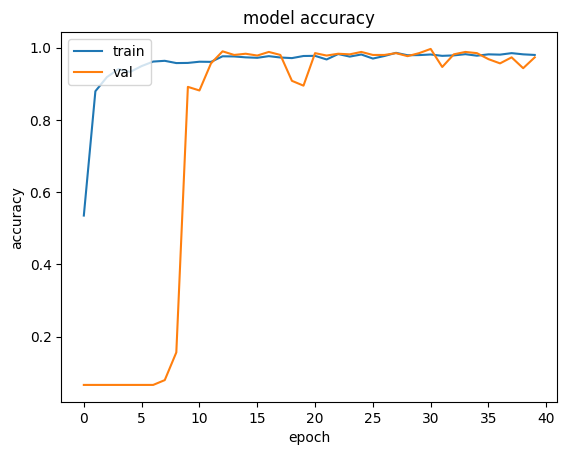

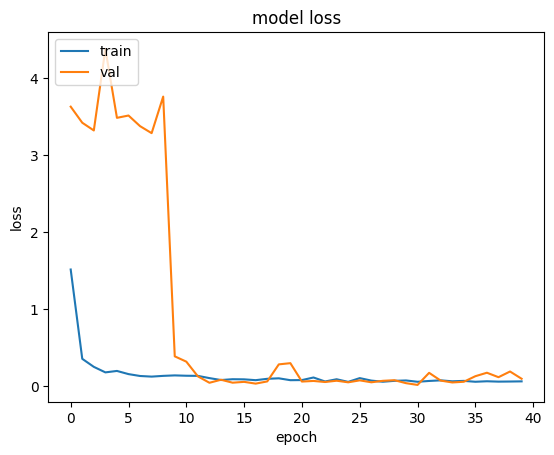

In [20]:
model_args_s = AttrDict()
args_dict = {
    "train_data_set": "large_train_set",
    "val_data_set": "large_val_set",
    "gpus": 1,
    "nepochs": 40,
    "learning_rate": 1e-4,
    "batch_size": 80,
}

model_args_s.update(args_dict)

print_opts(model_args_s)

large_model = generate_model(False)

large_history = train_evaluate(large_model, model_args_s, large_train_set, large_val_set)

plot_accuracy(large_history)
plot_loss(large_history)
